# Analyzing single-lineage models

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from fractions import Fraction
from pathlib import Path
from time import time
from typing import Sequence

import arviz as az
import dask.dataframe as dd
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text
from pydantic import BaseModel

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.data_processing.common import head_tail
from speclet.data_processing.vectors import squish_array
from speclet.io import DataFile, data_path, project_root, temp_dir
from speclet.managers.posterior_data_manager import PosteriorDataManager as PostDataMan
from speclet.managers.posterior_data_manager import PosteriorDataManagers as PostDataMen
from speclet.model_configuration import read_model_configurations
from speclet.plot import set_speclet_theme
from speclet.plot.color_pal import pal_to_legend_handles
from speclet.project_configuration import arviz_config, get_model_configuration_file
from speclet.project_enums import ModelFitMethod

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

# File paths
config_path = project_root() / get_model_configuration_file()

### Data

#### Model posteriors

In [5]:
model_configs = read_model_configurations(config_path, active_only=True)
f"Number of configurations: {len(model_configs.configurations)}"

'Number of configurations: 43'

In [6]:
model_names = [c.name for c in model_configs.configurations]
model_names.sort()
pattern = r"(?<=hnb-single-lineage-).*$"
sublineage_names = [re.findall(pattern, m)[0] for m in model_names]
sublineage_names = [n.replace("_", " ") for n in sublineage_names]

postmen = PostDataMen(
    names=model_names,
    fit_methods=ModelFitMethod.PYMC_NUMPYRO,
    config_paths=config_path,
    keys=sublineage_names,
)

In [7]:
postmen.keys

['bile duct (cholangiocarcinoma)',
 'bile duct (gallbladder adenocarcinoma)',
 'blood (ALL)',
 'blood (AML)',
 'blood (CLL)',
 'blood (CML)',
 'bone (Ewing sarcoma)',
 'bone (chordoma)',
 'bone (osteosarcoma)',
 'breast',
 'central nervous system (glioma)',
 'central nervous system (medulloblastoma)',
 'cervix (cervical carcinoma)',
 'cervix (cervical squamous)',
 'colorectal',
 'esophagus (esophagus adenocarcinoma)',
 'esophagus (esophagus squamous)',
 'eye (uveal melanoma)',
 'gastric (gastric adenocarcinoma)',
 'kidney (renal cell carcinoma)',
 'liver (hepatocellular carcinoma)',
 'lung (NSCLC)',
 'lung (SCLC)',
 'lung (mesothelioma)',
 'lymphocyte (hodgkin lymphoma)',
 'lymphocyte (lymphoma unspecified)',
 'lymphocyte (non hodgkin lymphoma)',
 'ovary (ovary adenocarcinoma)',
 'pancreas',
 'peripheral nervous system (neuroblastoma)',
 'plasma cell (multiple myeloma)',
 'prostate',
 'skin (melanoma)',
 'skin (skin squamous)',
 'soft tissue (ATRT)',
 'soft tissue (liposarcoma)',
 'sof

In [8]:
len(postmen)

43

In [9]:
sub_to_lineage = {pm.id: pm.id.split(" (")[0] for pm in postmen.posteriors}
lineages = list(set(sub_to_lineage.values()))
lineages.sort()

In [10]:
sublineage_cmap = sns.color_palette("Spectral", n_colors=len(postmen), as_cmap=False)
sublineage_pal = {line: sublineage_cmap[i] for i, line in enumerate(sublineage_names)}

lineage_cmap = sns.color_palette("terrain", n_colors=len(lineages), as_cmap=False)
lineage_pal = {line: lineage_cmap[i] for i, line in enumerate(lineages)}

### CRISPR screen data

In [11]:
prostate_data = dd.read_csv(
    postmen["prostate"].data_file, low_memory=False, dtype={"age": "float64"}
).query("screen == 'broad'")

In [12]:
prostate_data.head(3)

sgrna                 replicate_id       lfc  p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450            3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518            3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114            3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   

           lineage_subtype  primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma             metastasis     True  59.0  
1  prostate_adenocarcinoma             metastasis     True  59.0  
2  prostate_adenocarcinoma             metastasis     True  59.0  

[3 rows x 25 columns]

In [13]:
sgrna_data = (
    prostate_data[["sgrna", "hugo_symbol", "sgrna_target_chr", "sgrna_target_pos"]]
    .drop_duplicates()
    .compute()
    .sort_values(["hugo_symbol", "sgrna"])
    .reset_index(drop=True)
)
sgrna_data.head(3)

sgrna hugo_symbol sgrna_target_chr  sgrna_target_pos
0  GGAAGTCTGGAGTCTCCAGG        A1BG               19          58353109
1  GTGGACTTCCAGCTACGGCG        A1BG               19          58351569
2  GTGTGCCGAGGTGTGCTGCG        A1BG               19          58352467

In [14]:
assert len(sgrna_data) == sgrna_data["sgrna"].nunique()

## Analysis

### Gather sgRNA|gene varying intercept

In [15]:
STASH_DIR = temp_dir() / "100_105_notebook-stash"
if not STASH_DIR.exists():
    STASH_DIR.mkdir()

In [16]:
# def _extract_varying_intercept_summary(
#     pm: PostDataMan,
#     sgrna_df: pd.DataFrame,
#     lineage_map: dict[str, str],
#     stash: bool = True,
# ) -> pd.DataFrame:
#     lineage_subtype = pm.id
#     lineage = lineage_map[pm.id]

#     # a_post_fp = STASH_DIR / f"a-post-df_{pm.id}"
#     mu_a_post_fp = STASH_DIR / f"mu-a-post-df_{pm.id}"
#     # if stash and a_post_fp.exists():
#     #     a_post = pd.read_csv(a_post_fp)
#     # else:
#     #     a_post = (
#     #         az.summary(pm.trace, var_names=["a"], kind="stats")
#     #         .pipe(extract_coords_param_names, names=["sgrna"])
#     #         .reset_index(drop=True)
#     #         .merge(sgrna_df, on="sgrna", how="left", validate="one_to_one")
#     #         .assign(lineage_subtype=lineage_subtype, lineage=lineage)
#     #     )
#     #     a_post.to_csv(a_post_fp, index=False)

#     if stash and mu_a_post_fp.exists():
#         mu_a_post = pd.read_csv(mu_a_post_fp)
#     else:
#         mu_a_post = (
#             az.summary(pm.trace, var_names=["mu_a"], kind="stats")
#             .pipe(extract_coords_param_names, names=["hugo_symbol"])
#             .reset_index(drop=True)
#             .assign(lineage_subtype=lineage_subtype, lineage=lineage)
#         )
#         mu_a_post.to_csv(mu_a_post_fp, index=False)

#     return mu_a_post


def get_mu_a_summary(
    pm: PostDataMan, lineage_map: dict[str, str], stash: bool = True
) -> pd.DataFrame:
    lineage_subtype = pm.id
    lineage = lineage_map[pm.id]

    stash_fp = STASH_DIR / f"mu-a-post-df_{pm.id}"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    mu_a_post = (
        pm.posterior_summary.query("var_name == 'mu_a'")
        .reset_index(drop=True)
        .pipe(extract_coords_param_names, col="parameter", names=["hugo_symbol"])
        .drop(columns=["parameter"])
        .assign(lineage_subtype=lineage_subtype, lineage=lineage)
    )
    mu_a_post.to_csv(stash_fp, index=False)
    return mu_a_post

In [17]:
intercept_posteriors = {
    pm.id: get_mu_a_summary(pm, lineage_map=sub_to_lineage, stash=True)
    for pm in postmen.as_dict().values()
}

In [18]:
mu_a_post_df = (
    pd.concat(list(intercept_posteriors.values()))
    .sort_values(["lineage", "lineage_subtype", "hugo_symbol"])
    .reset_index(drop=True)
)
mu_a_post_df.head(3)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
0  0.337  0.125     0.136      0.535      0.002    0.002    3351.0    2677.0   
1  0.268  0.124     0.069      0.462      0.002    0.002    3071.0    3020.0   
2  0.178  0.127    -0.026      0.374      0.002    0.002    2829.0    3058.0   

   r_hat var_name hugo_symbol                 lineage_subtype    lineage  
0    1.0     mu_a        A1BG  bile duct (cholangiocarcinoma)  bile duct  
1    1.0     mu_a        A1CF  bile duct (cholangiocarcinoma)  bile duct  
2    1.0     mu_a         A2M  bile duct (cholangiocarcinoma)  bile duct

In [19]:
def extract_sublineage(s: str) -> str:
    if "(" not in s:
        return s
    return s.split("(")[1].replace(")", "")


def axis_labels_to_sublineage(lbl: Text) -> Text:
    lbl.set_text(extract_sublineage(lbl.get_text()))
    return lbl

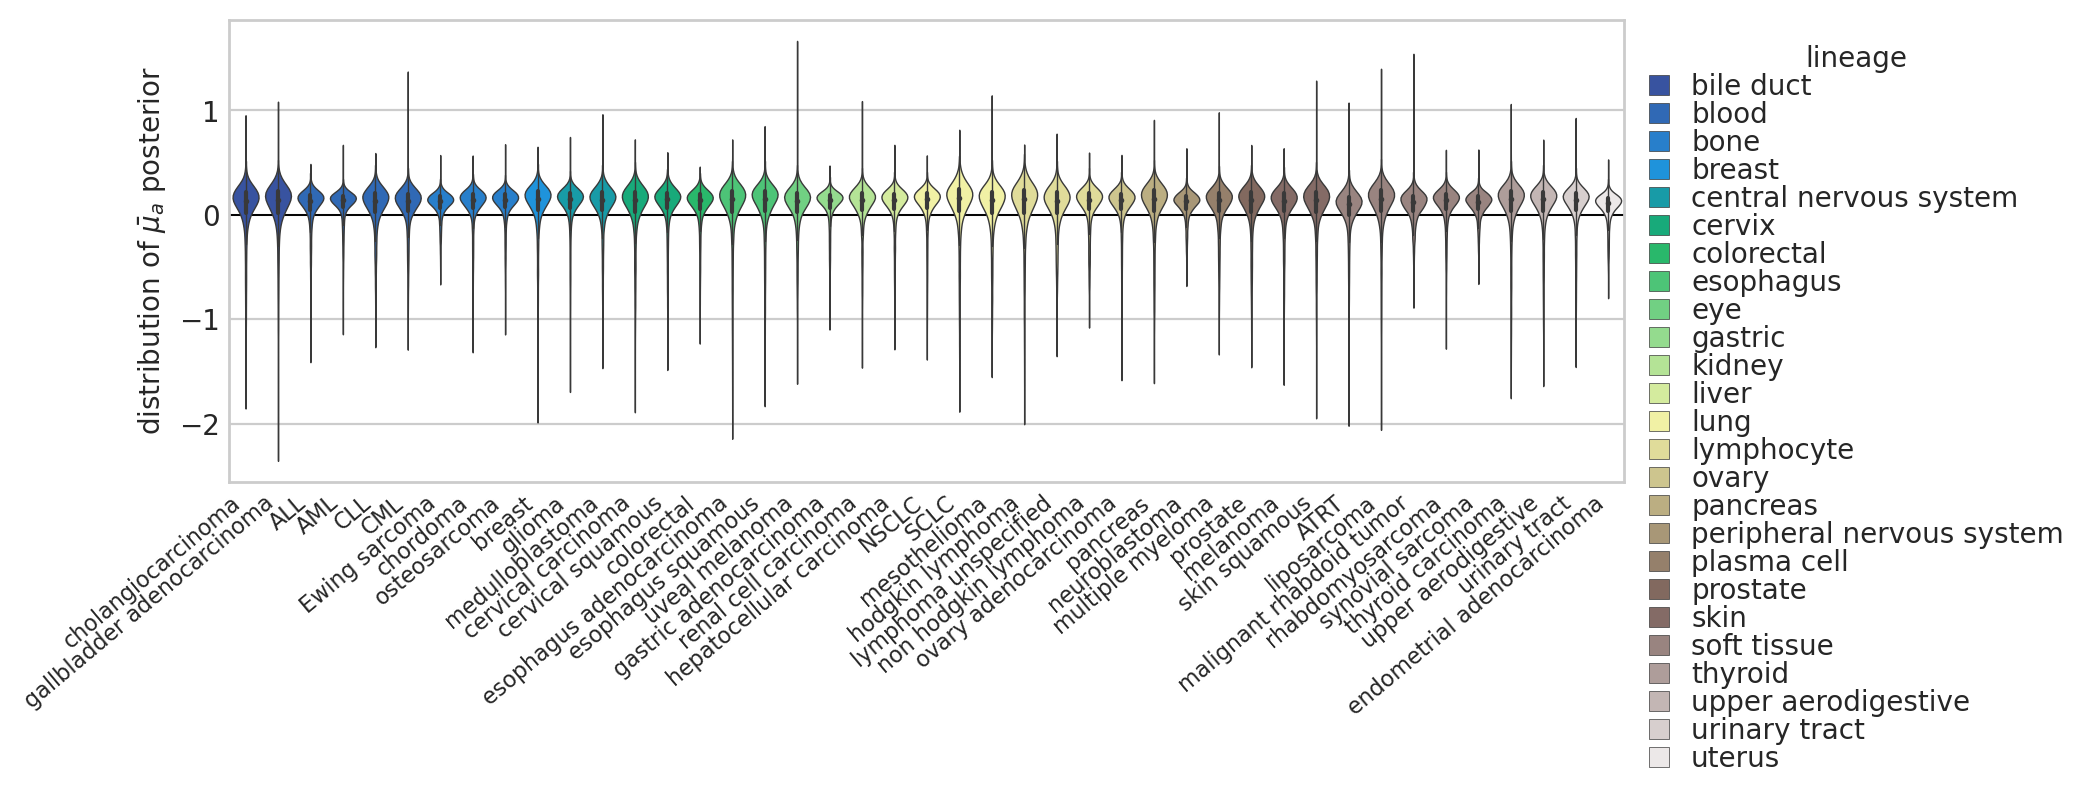

In [20]:
_, ax = plt.subplots(figsize=(9, 3))
ax.axhline(0, color="k", lw=0.7, zorder=1)
sns.violinplot(
    data=mu_a_post_df,
    x="lineage_subtype",
    y="mean",
    hue="lineage",
    palette=lineage_pal,
    dodge=False,
    linewidth=0.5,
    ax=ax,
)
xlbls = [axis_labels_to_sublineage(lbl) for lbl in ax.get_xticklabels()]
ax.set_xticklabels(xlbls, rotation=40, ha="right", size=8)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="lineage",
    handlelength=0.7,
    handleheight=0.7,
    labelspacing=0,
)
ax.set_xlabel(None)
ax.set_ylabel(r"distribution of $\bar{\mu}_a$ posterior")
plt.show()

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


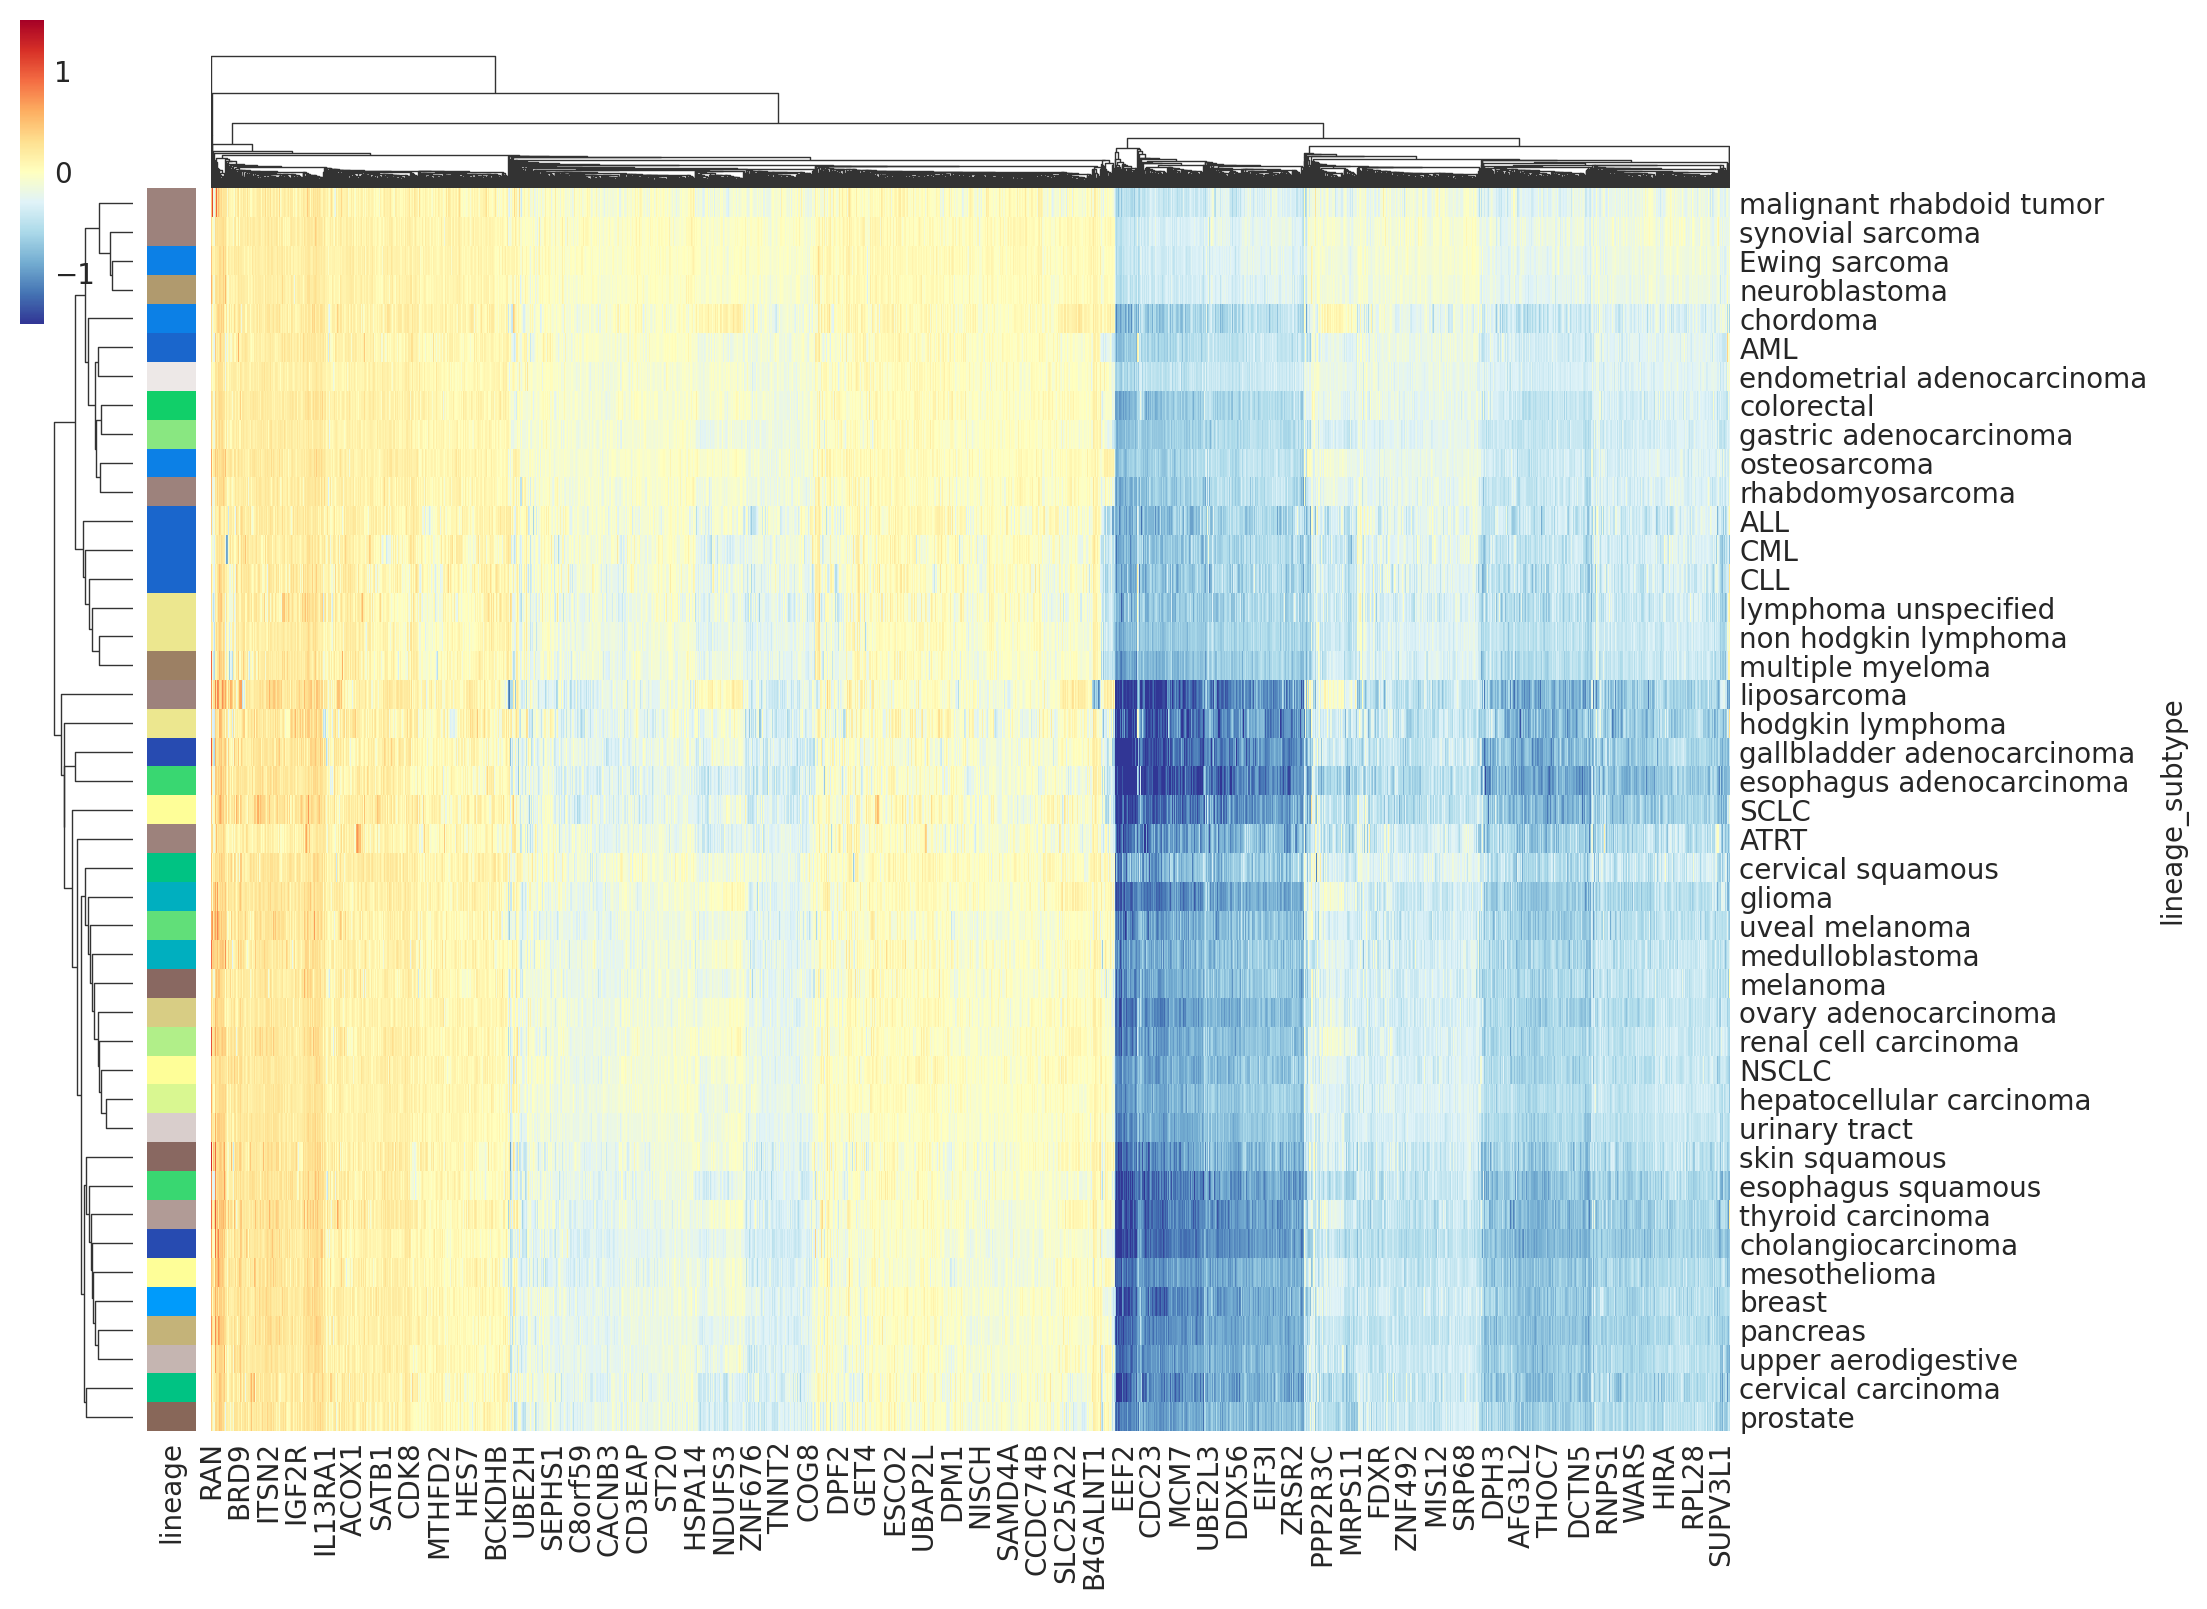

In [21]:
mu_a_post_X = mu_a_post_df.pivot_wider(
    "lineage_subtype", names_from="hugo_symbol", values_from="mean"
).set_index("lineage_subtype")

# Top 80% most variable genes.
variances = mu_a_post_X.var(axis=0)
mu_a_post_X = mu_a_post_X.loc[:, np.quantile(variances, q=0.8) < variances]

# Row color dictionary.
row_colors = (
    pd.DataFrame({"index": mu_a_post_X.index})
    .assign(lineage=lambda d: d["index"].map(sub_to_lineage).map(lineage_pal))
    .set_index("index")
)

# Clustermap.
cg = sns.clustermap(
    mu_a_post_X,
    figsize=(12, 8),
    dendrogram_ratio=(0.05, 0.1),
    row_colors=row_colors,
    cmap="RdYlBu_r",
    center=0,
    vmin=-1.5,
    vmax=1.5,
    yticklabels=1,
    cbar_pos=(0, 0.81, 0.01, 0.19),
)
ylbls = [axis_labels_to_sublineage(lbl) for lbl in cg.ax_heatmap.get_yticklabels()]
cg.ax_heatmap.set_yticklabels(ylbls)
plt.show()

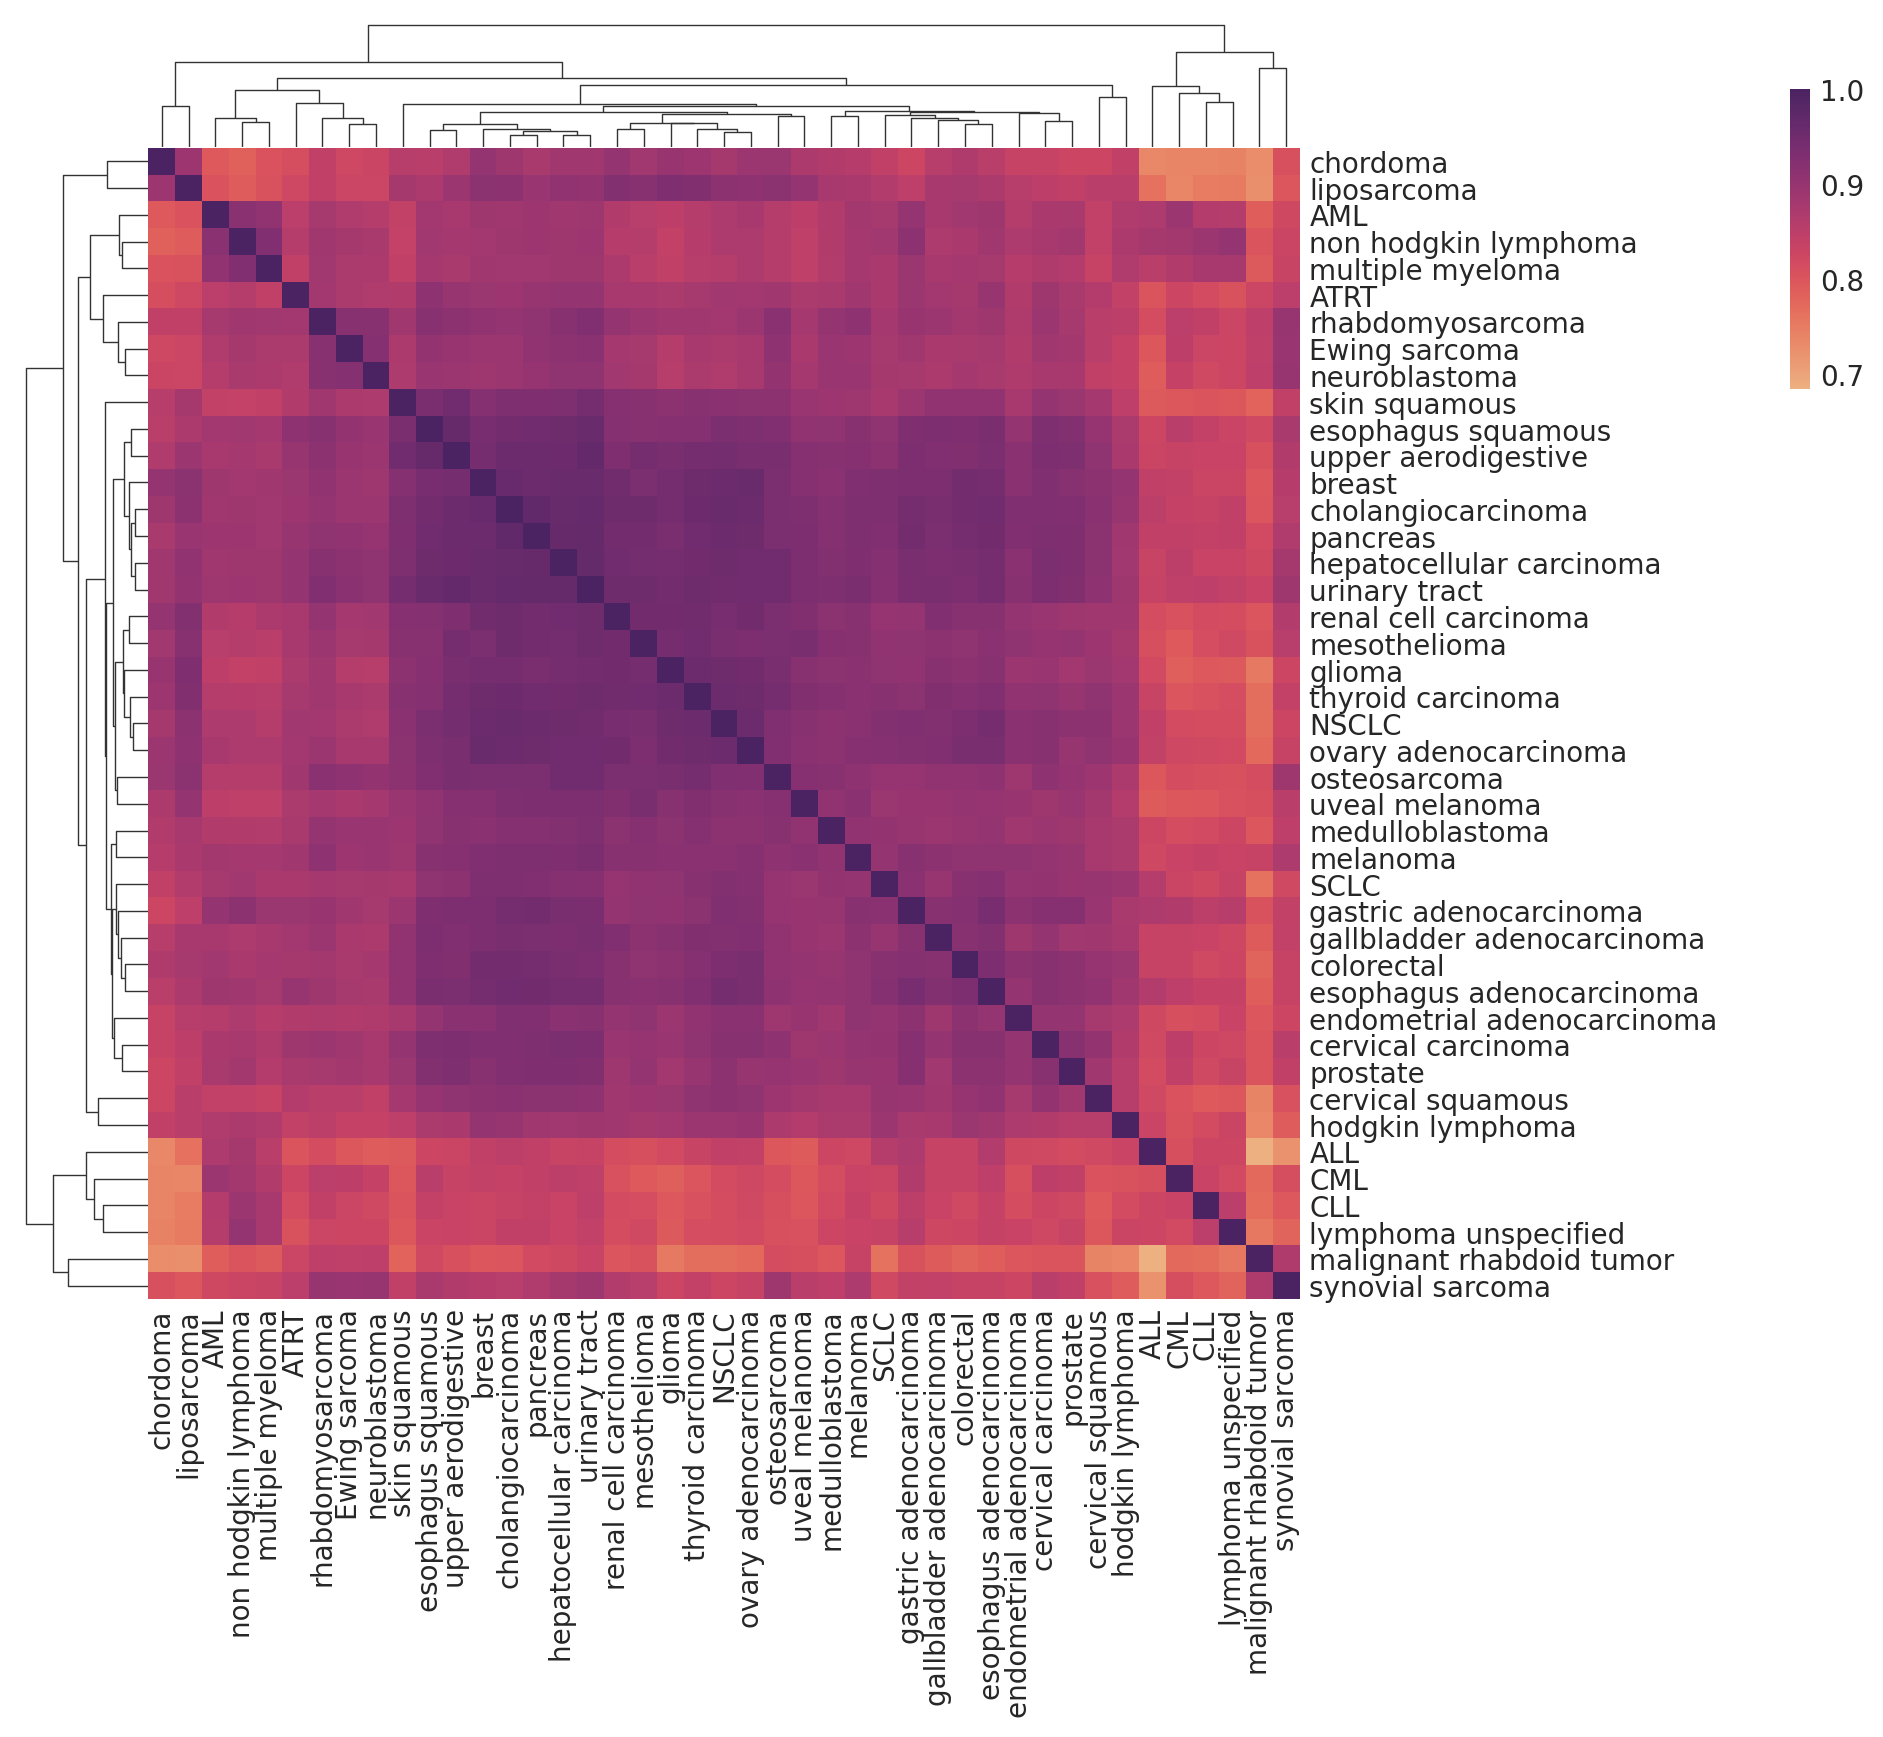

In [22]:
mu_a_corr = mu_a_post_X.T.corr()
cg = sns.clustermap(
    mu_a_corr,
    cmap="flare",
    vmin=mu_a_corr.min().min(),
    vmax=1,
    figsize=(10, 10),
    dendrogram_ratio=(0.1, 0.1),
    cbar_pos=(0.9, 0.8, 0.01, 0.15),
)
cg.ax_heatmap.set_xlabel(None)
cg.ax_heatmap.set_ylabel(None)
ylbls = [axis_labels_to_sublineage(lbl) for lbl in cg.ax_heatmap.get_yticklabels()]
cg.ax_heatmap.set_yticklabels(ylbls)
xlbls = [axis_labels_to_sublineage(lbl) for lbl in cg.ax_heatmap.get_xticklabels()]
cg.ax_heatmap.set_xticklabels(xlbls)
plt.show()

In [23]:
head_mu_a = (
    mu_a_post_df.sort_values(["lineage_subtype", "mean"], ascending=(True, False))
    .groupby("lineage_subtype")
    .head(100)
    .reset_index(drop=True)
)
tail_mu_a = (
    mu_a_post_df.sort_values(["lineage_subtype", "mean"], ascending=(True, False))
    .groupby("lineage_subtype")
    .tail(100)
    .reset_index(drop=True)
)

In [24]:
GENE_SETS = [
    "KEGG_2021_Human",
    "MSigDB_Hallmark_2020",
    "MSigDB_Oncogenic_Signatures",
]


def enrichr(df: pd.DataFrame, stash: bool = True) -> pd.DataFrame:
    genes = list(df["hugo_symbol"].unique())
    genes.sort()
    genes_hash = str(hash("__".join(genes)))
    stash_fp = STASH_DIR / f"enrichr-{genes_hash}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    enr = gp.enrichr(
        gene_list=genes,
        gene_sets=GENE_SETS,
        organism="human",
        outdir=None,
        cutoff=1,
        top_term=int(1e6),
    )
    res = enr.results.clean_names()
    res.to_csv(stash_fp, index=False)
    return res


def enrichr_post(res_df: pd.DataFrame) -> pd.DataFrame:
    return res_df.assign(
        overlap_frac=lambda d: [float(Fraction(x)) for x in d["overlap"]],
        n_overlap=lambda d: [int(x.split("/")[0]) for x in d["overlap"]],
    )

In [25]:
def ssgsea(df: pd.DataFrame, stash: bool = True) -> pd.DataFrame:
    X = df.pivot_wider(
        "hugo_symbol", names_from="lineage_subtype", values_from="mean"
    ).set_index("hugo_symbol")

    stash_fp = STASH_DIR / f"ssgsea-mu-a-posterior.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    ss_res = gp.ssgsea(data=X, gene_sets=GENE_SETS).res2d.clean_names()
    ss_res.to_csv(stash_fp, index=False)
    return ss_res


def post_ssgsea(ssgsea_res: pd.DataFrame) -> pd.DataFrame:
    return (
        ssgsea_res.rename(columns={"term": "geneset_term", "name": "lineage_subtype"})
        .assign(
            gene_set=lambda d: [t.split("__")[0] for t in d["geneset_term"]],
            term=lambda d: [t.split("__")[1] for t in d["geneset_term"]],
        )
        .rename(columns={"tag_%": "tag_perc", "gene_%": "gene_perc"})
    )

In [26]:
enrichr_res_up = (
    head_mu_a.groupby("lineage_subtype")
    .apply(enrichr)
    .reset_index(drop=False)
    .assign(lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage))
    .drop(columns=["level_1"])
    .pipe(enrichr_post)
)
enrichr_res_dn = (
    tail_mu_a.groupby("lineage_subtype")
    .apply(enrichr)
    .reset_index(drop=False)
    .assign(lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage))
    .drop(columns=["level_1"])
    .pipe(enrichr_post)
)

ssgsea_res = (
    ssgsea(mu_a_post_df.copy())
    .pipe(post_ssgsea)
    .assign(lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage))
)

In [27]:
enrichr_res_up.head(3)

lineage_subtype         gene_set  \
0  bile duct (cholangiocarcinoma)  KEGG_2021_Human   
1  bile duct (cholangiocarcinoma)  KEGG_2021_Human   
2  bile duct (cholangiocarcinoma)  KEGG_2021_Human   

                                      term overlap       p_value  \
0  Human T-cell leukemia virus 1 infection  10/219  1.479654e-07   
1                    p53 signaling pathway    6/73  1.743586e-06   
2                      Cellular senescence   7/156  1.338636e-05   

   adjusted_p_value  old_p_value  old_adjusted_p_value  odds_ratio  \
0          0.000026            0                     0   10.468368   
1          0.000153            0                     0   18.894570   
2          0.000781            0                     0    9.977412   

   combined_score                                              genes  \
0      164.628558  MAPK9;CDKN1A;CDKN2C;CHEK2;PTEN;ATM;TP53;ETS1;C...   
1      250.533811                  CDKN1A;CHEK2;PTEN;PMAIP1;ATM;TP53   
2      111.959280              HIPK4;CDKN1A;CHEK2;PTEN;ATM;TP53;ETS1   

     lineage  overlap_frac  n_overlap  
0  bile duct      0.045662         10  
1  bile duct      0.082192          6  
2  bile duct      0.044872          7

In [28]:
ssgsea_res.head(3)

lineage_subtype  \
0  gastric (gastric adenocarcinoma)   
1                          prostate   
2                soft tissue (ATRT)   

                                   geneset_term           es       nes  \
0                     KEGG_2021_Human__Ribosome -7829.043830 -0.642003   
1  KEGG_2021_Human__Aminoacyl-tRNA biosynthesis -7815.822238 -0.640918   
2  KEGG_2021_Human__Aminoacyl-tRNA biosynthesis -7738.572313 -0.634584   

  tag_perc gene_perc                                         lead_genes  \
0  126/158    14.50%  RPL12;SNRPD1;RPS6;RPSA;RPS3A;RPL7A;RPL17;RPL6;...   
1    25/66    14.48%  FARSB;RPL18A;HARS2;AARS2;MARS2;RRS1;NUP43;PSMD...   
2    25/66    15.61%  FARSB;YARS2;CDC7;EARS2;SNAPC3;POP1;AARS2;ISY1;...   

          gene_set                         term      lineage  
0  KEGG_2021_Human                     Ribosome      gastric  
1  KEGG_2021_Human  Aminoacyl-tRNA biosynthesis     prostate  
2  KEGG_2021_Human  Aminoacyl-tRNA biosynthesis  soft tissue

In [29]:
enrichr_res_up["term"].nunique(), enrichr_res_dn["term"].nunique()

(538, 357)

In [30]:
enrichr_res_up["gene_set"].unique()

array(['KEGG_2021_Human', 'MSigDB_Hallmark_2020',
       'MSigDB_Oncogenic_Signatures'], dtype=object)

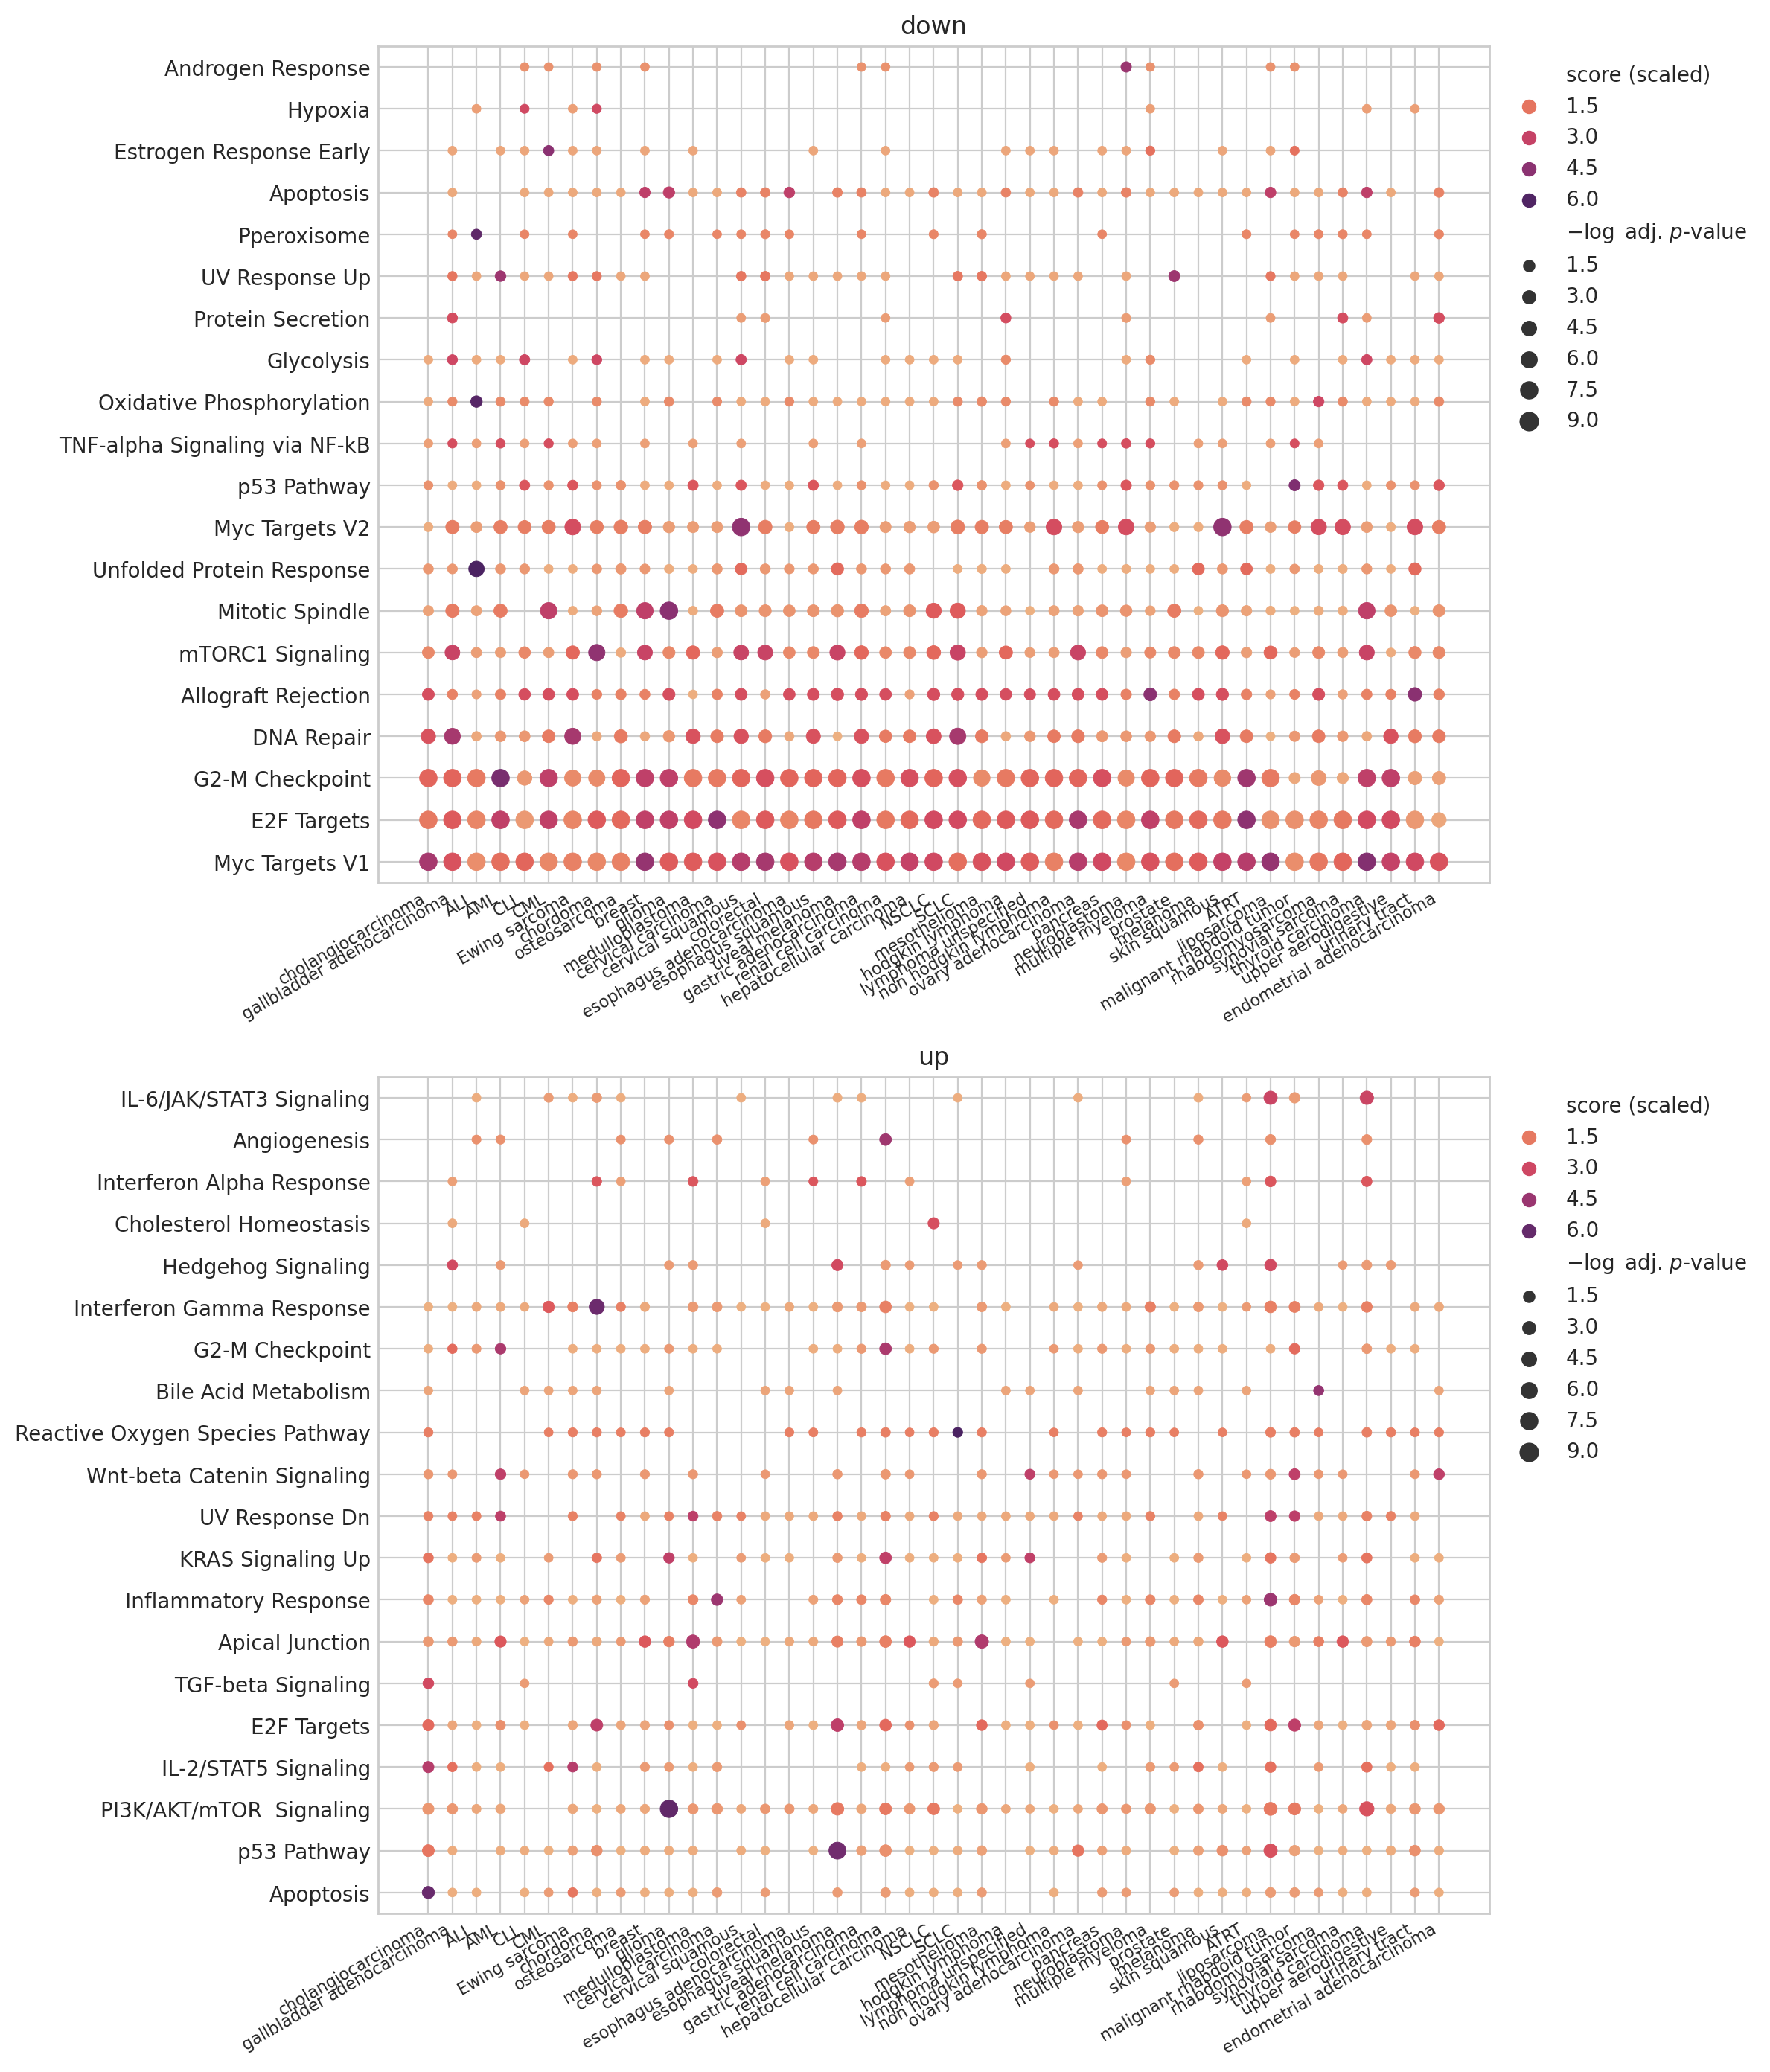

In [35]:
def grouped_zscore(df: pd.DataFrame, grp_cols: list[str], value: str) -> pd.DataFrame:
    def f(_df: pd.DataFrame) -> pd.DataFrame:
        x = _df[value]
        _df[value] = x / np.std(x)
        return _df

    return df.groupby(grp_cols).apply(f)


plot_df = (
    pd.concat(
        [enrichr_res_up.assign(direction="up"), enrichr_res_dn.assign(direction="down")]
    )
    .query("gene_set == 'MSigDB_Hallmark_2020'")
    .reset_index(drop=True)
)
fig, axes = plt.subplots(nrows=2, figsize=(12, 14))

for ax, (direction, df) in zip(axes, plot_df.groupby("direction")):
    term_variances = df.groupby("term")["combined_score"].var()
    term_variances = term_variances[~np.isnan(term_variances)]
    q = np.quantile(term_variances, 1 - (20 / len(term_variances)))
    top_var_terms = list(term_variances[q <= term_variances].index)

    df = (
        df.copy()
        .filter_column_isin("term", top_var_terms)
        .assign(
            adjusted_p_value=lambda d: squish_array(
                d["adjusted_p_value"], lower=10e-5, upper=1
            )
        )
        .assign(neg_log_adj_p_val=lambda d: -np.log(d["adjusted_p_value"]))
        .pipe(grouped_zscore, grp_cols=["term"], value="combined_score")
        .rename(
            columns={
                "neg_log_adj_p_val": r"$-\log$ adj. $p$-value",
                "overlap_frac": "overlap frac.",
                "combined_score": "score (scaled)",
            }
        )
    )

    ax.set_title(direction)
    sns.scatterplot(
        data=df,
        x="lineage_subtype",
        y="term",
        hue="score (scaled)",
        size=r"$-\log$ adj. $p$-value",
        ax=ax,
        palette="flare",
        edgecolor=None,
    )
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    xlbls = [extract_sublineage(lbl) for lbl in sorted(df["lineage_subtype"].unique())]
    ax.set_xticks(
        ticks=np.arange(len(xlbls)), labels=xlbls, rotation=30, ha="right", size=8
    )
    ax.set_ylim(-0.5, df["term"].nunique() - 0.5)

fig.tight_layout()
plt.show()

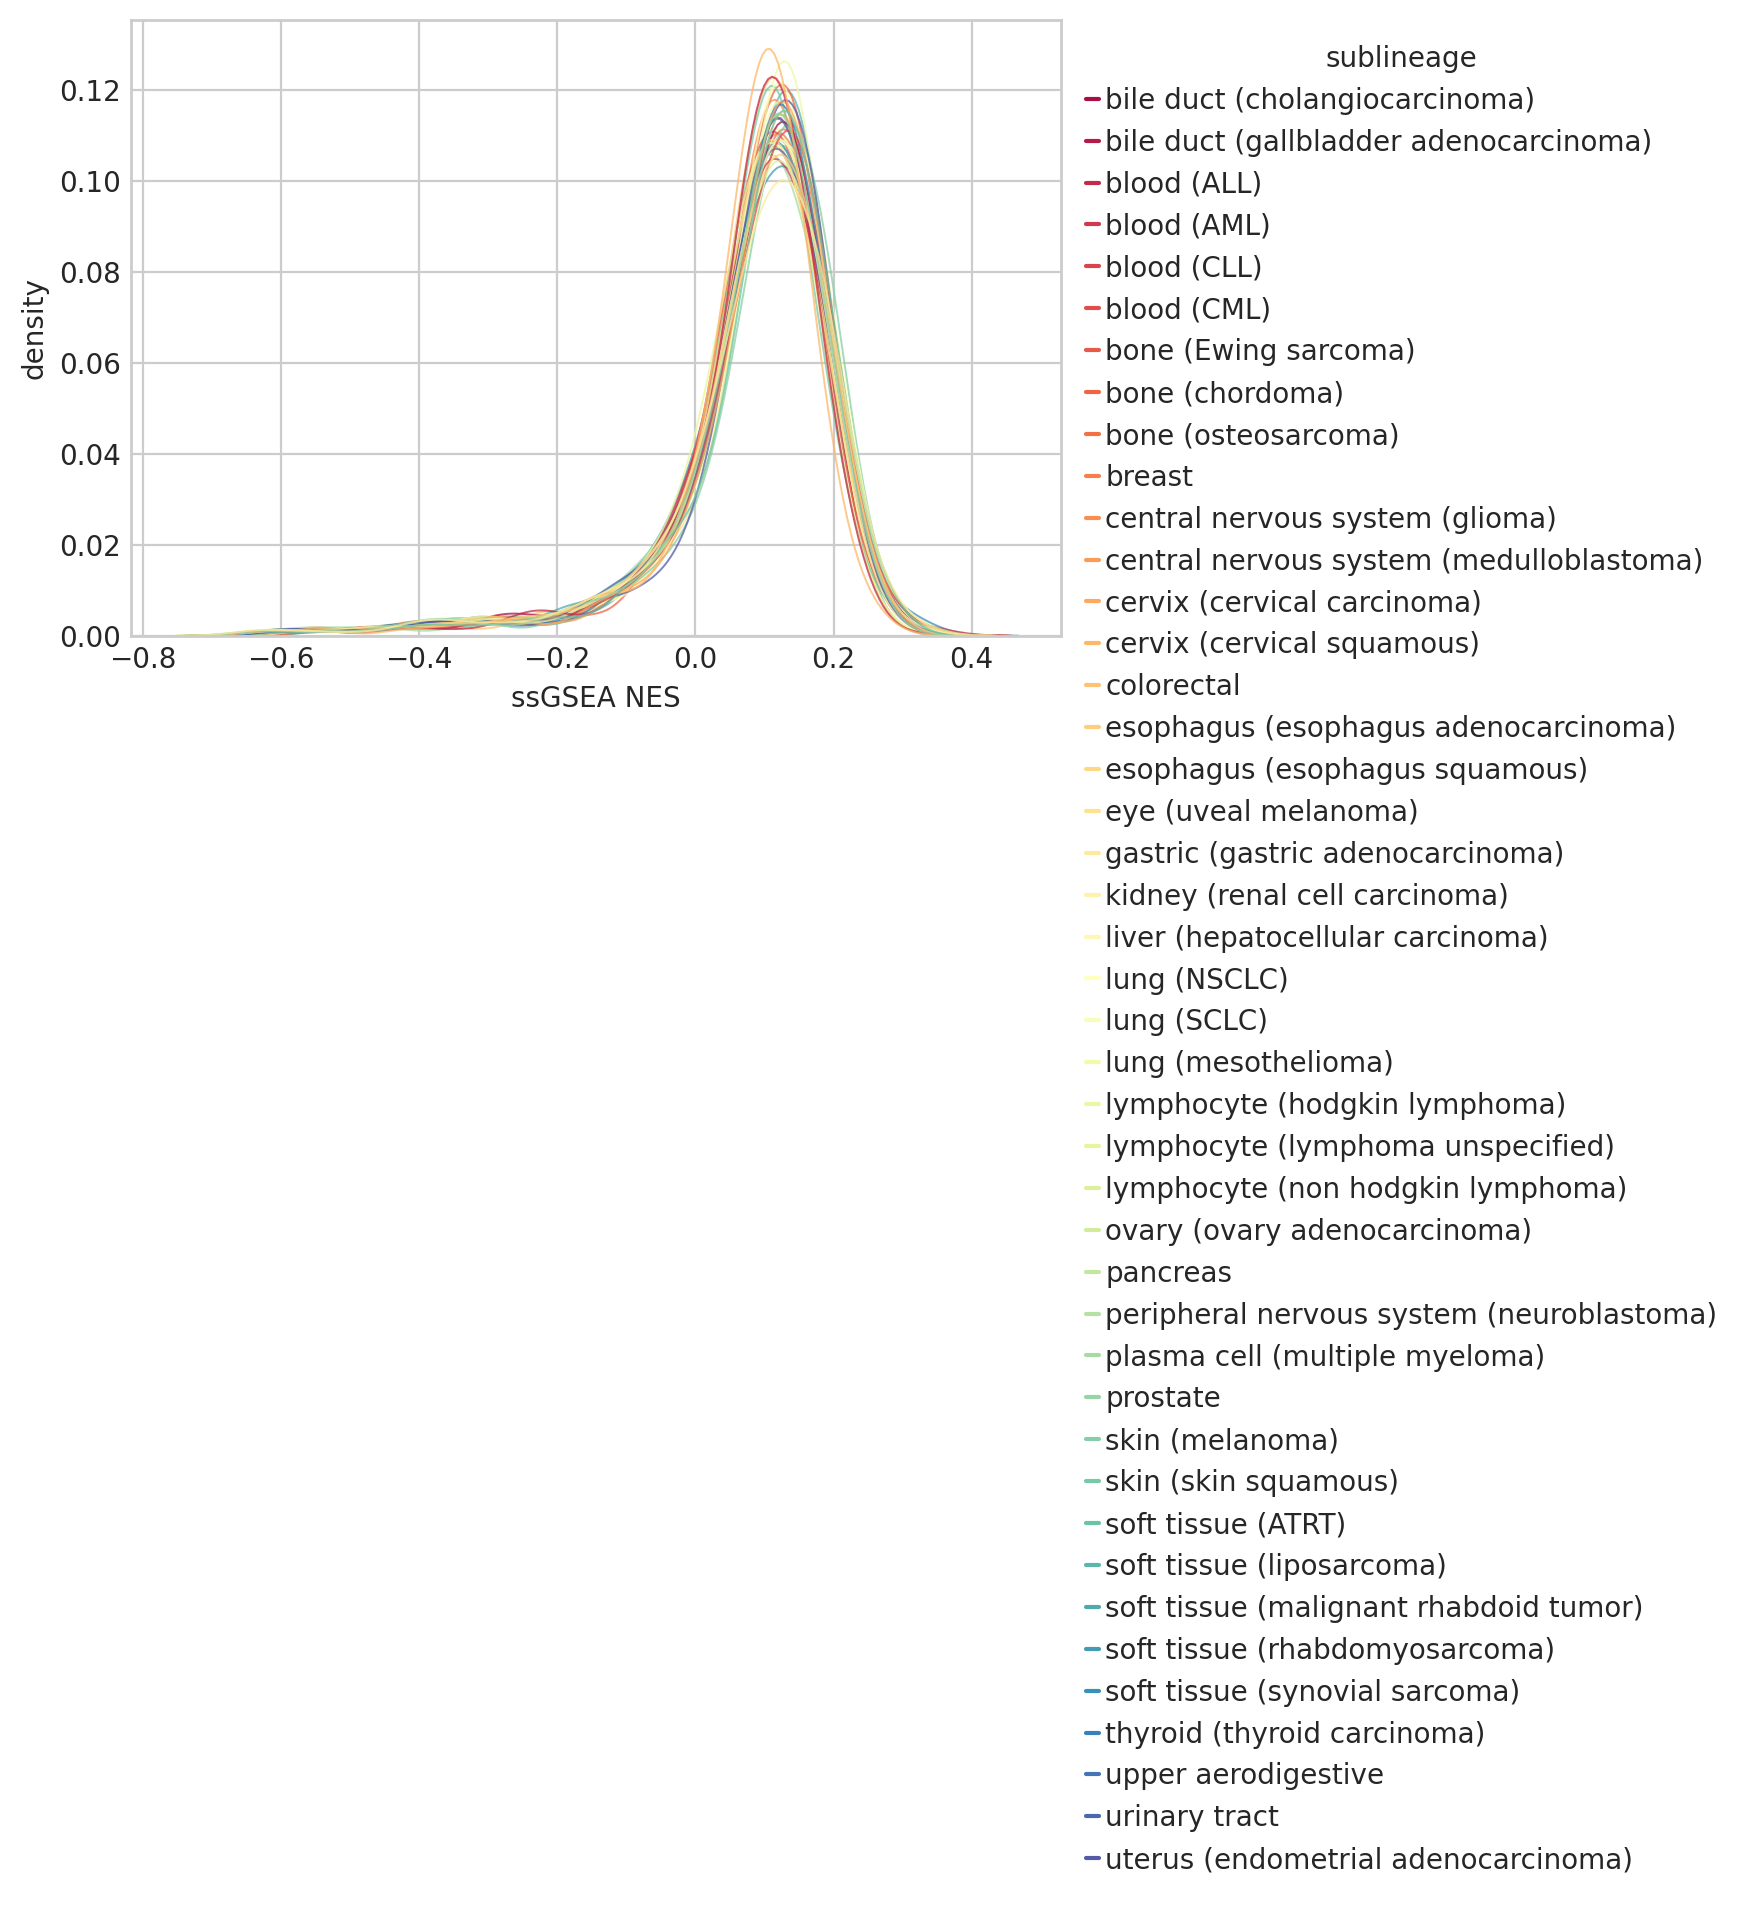

In [32]:
_, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(
    data=ssgsea_res,
    x="nes",
    hue="lineage_subtype",
    ax=ax,
    palette=sublineage_pal,
    lw=0.7,
    alpha=0.75,
)

pal = {
    k: v for k, v in sublineage_pal.items() if k in set(ssgsea_res["lineage_subtype"])
}

ax.legend(
    handles=pal_to_legend_handles(pal),
    title="sublineage",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    handlelength=0.5,
    handletextpad=0.2,
)
ax.set_xlabel("ssGSEA NES")
ax.set_ylabel("density")
plt.show()

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


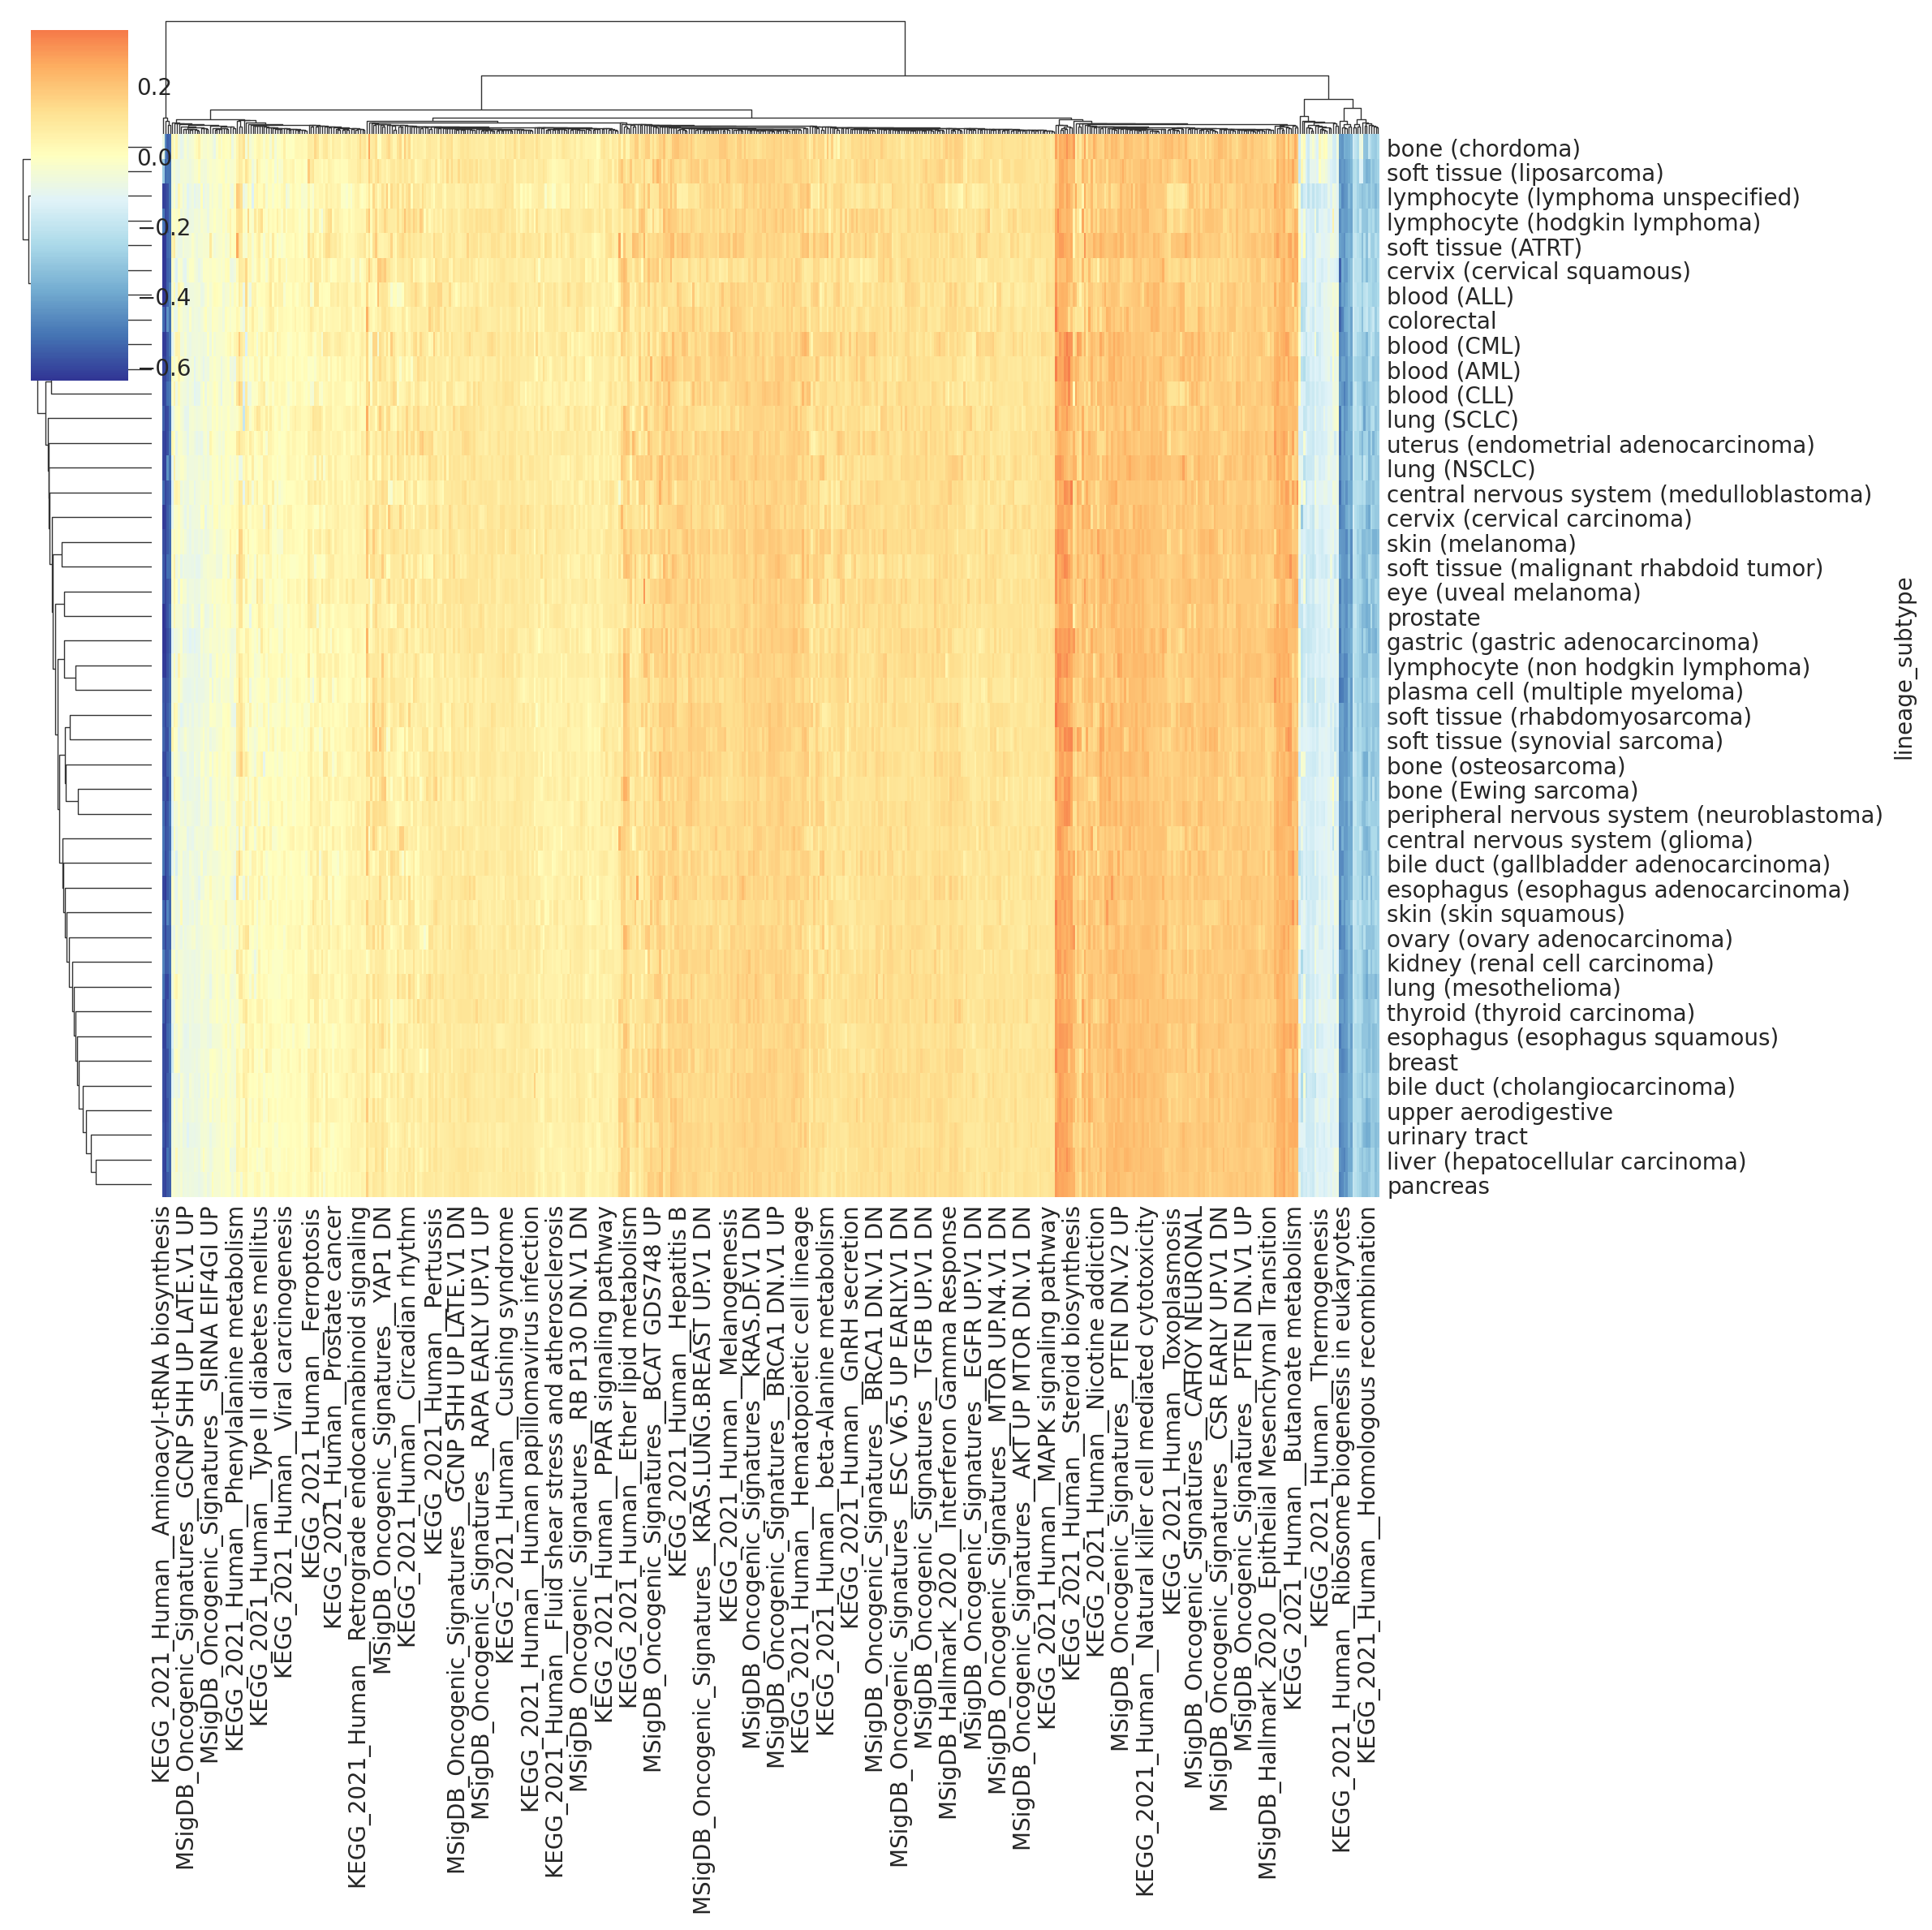

In [33]:
ssgsea_X = ssgsea_res.pivot_wider(
    "lineage_subtype", names_from="geneset_term", values_from="nes"
).set_index("lineage_subtype")
sns.clustermap(
    ssgsea_X, figsize=(12, 12), dendrogram_ratio=(0.1, 0.1), cmap="RdYlBu_r", center=0
)

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m